# Taller de Futbol Analytics

La idea de este taller es bla bla ... queremos que se lleven bla bla...

In [ ]:
# Primero importamos unas librerías de Python que vamos a usar a lo largo del notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV


from adjustText import adjust_text

In [30]:
# Obtenemos los datos desde el archivo df_reducido.csv
df = pd.read_csv("datasets_procesados/df_reducido.csv")

In [31]:
# Podemos obtener una primera visualización de los datos viendo sus primeras 5 filas con el comando head()
display(df.head())

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
0,Erling Haaland,Manchester City,Premier League,FW,24,28,2480,21,3,20.8,...,11,2,0,24,0.86,27.6,5,1,99,54
1,Jude Bellingham,Real Madrid,La Liga,MF,21,24,1983,8,7,8.9,...,28,3,1,15,0.56,22.0,28,0,44,16
2,Kylian Mbappé,Real Madrid,La Liga,FW,26,28,2420,22,3,20.0,...,3,3,0,25,0.98,26.9,5,2,121,62
3,Bukayo Saka,Arsenal,Premier League,"FW,MF",23,18,1338,6,10,5.2,...,16,3,0,16,0.75,14.9,13,10,48,18
4,Jamal Musiala,Bayern Munich,Bundesliga,MF,22,25,1798,12,2,9.3,...,30,3,0,14,0.69,20.0,21,0,68,31


Fijense que en los datos que tenemos que tienen solo numeros, hay menos columnas (porque nos quedamos solo con las que tienen números)

In [32]:
# Con este comando podemos ver las columnas (o sea, toda la información que tenemos de cada jugador)
print(list(df.columns))

['Jugador', 'Equipo', 'Competición', 'Posición', 'Edad', 'Partidos', 'Minutos', 'Goles', 'Asistencias', 'xG', 'xAG', 'npxG', 'ValorMercado', 'PasesCompletados', 'IntentosPase', 'PctPasesCompletados', 'DistanciaTotalPases', 'DistanciaProgresiva', 'PasesClave', 'Entradas', 'Intercepciones', 'Bloqueos', 'TarjetasAmarillas', 'TarjetasRojas', 'Goles_Asistencias', 'xG_xAG', 'Equiv_90min', 'EntradasGanadas', 'AsistDesdeCruzados', 'Tiros', 'TirosAlArco']


También podemos usar gráficos para ver la información de manera más comprimida. Por ejemplo si queremos ver los goles y las asistencias de los jugadores, los podemos poner en un gráfico:

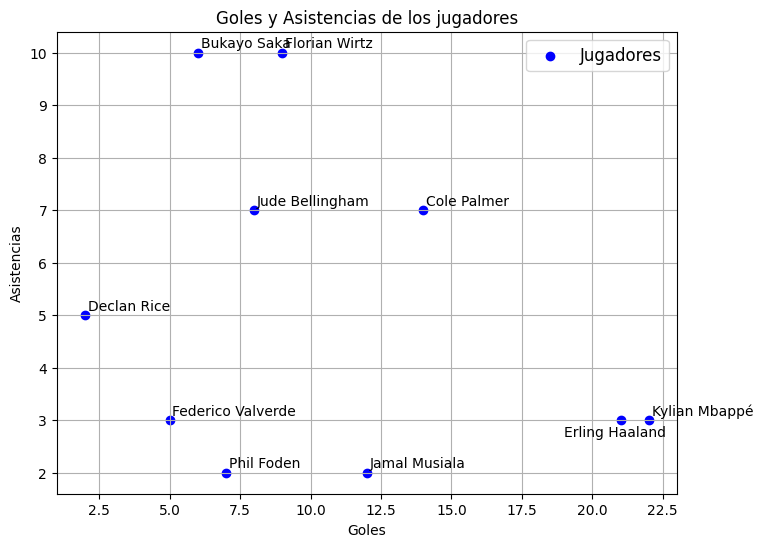

In [33]:
df_grafico=df[:10]
plt.figure(figsize=(8, 6))
plt.scatter(df_grafico['Goles'], df_grafico['Asistencias'], label="Jugadores", color="blue")
plt.text(df_grafico['Goles'][0]-2, df_grafico['Asistencias'][0]-0.3, df["Jugador"][0])
for i in range(1,10):
    plt.text(df_grafico['Goles'][i]+0.1, df_grafico['Asistencias'][i]+0.1, df["Jugador"][i])
plt.xlabel('Goles')
plt.ylabel('Asistencias')
plt.title('Goles y Asistencias de los jugadores')
plt.grid()
plt.legend(fontsize=12)
plt.show()

Se pone divertido cuando podemos ver un monton de estos datos. Podemos buscar relaciones entre las estadísticas de los futbolistas.

Elijamos dos columnas y veamos la relación:

In [34]:
# Acá capaz podrían jugar un poco con esto
primera_columna = 'PasesCompletados' # Pases completados cada 90 minutos
segunda_columna = 'Goles' # Tiros totales cada 90 minutos

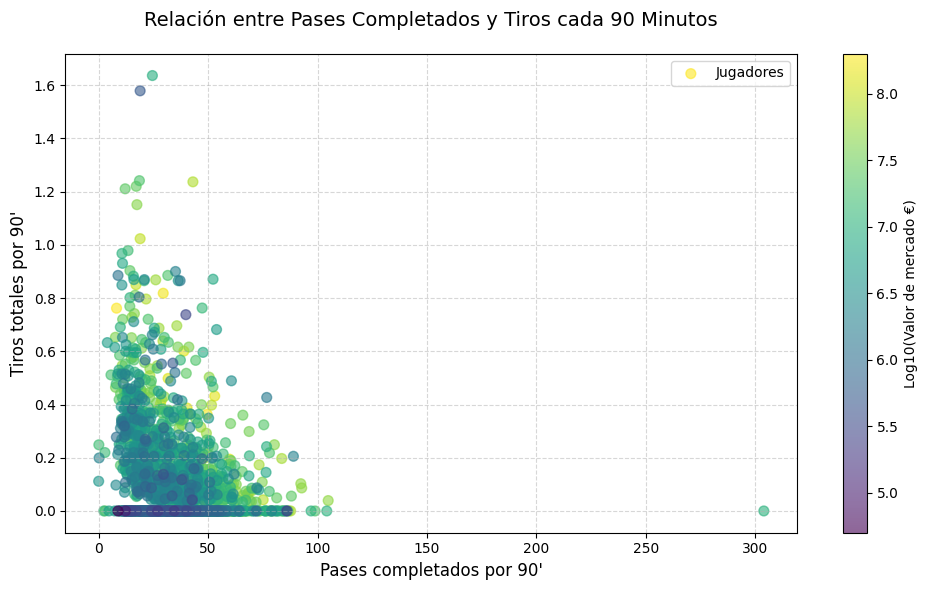

In [35]:
df_grafico = df[df["Minutos"] > 90] # Para el gráfico nos quedamos con los futbolistas que hayan jugado al menos 90 minutos

# Configuración de estilo
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Normalizar las métricas por 90 minutos
pases_90 = 90 * df_grafico[primera_columna] / df_grafico['Minutos'] # Cuantos pases hizo cada 90 minutos
tiros_90 = 90 * df_grafico[segunda_columna] / df_grafico['Minutos'] # Cuantos tiros al arco hizo cada 90 minutos

plt.scatter(
    x=pases_90,
    y=tiros_90,
    c=np.log10(df_grafico['ValorMercado']),  # Escala logarítmica base 10
    cmap='viridis',
    alpha=0.6,
    s=50
)
cbar = plt.colorbar()
cbar.set_label('Log10(Valor de mercado €)', fontsize=10)

# Títulos y etiquetas
plt.title('Relación entre Pases Completados y Tiros cada 90 Minutos', fontsize=14, pad=20)
plt.xlabel('Pases completados por 90\'', fontsize=12)
plt.ylabel('Tiros totales por 90\'', fontsize=12)

# Grid y leyenda
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Jugadores'], loc='upper right')

# Mostrar gráfico
plt.tight_layout()  # Evita cortes en etiquetas
plt.show()

Estuve experimentando con estas cosas. Pero habría que repensar varias cosas, como ponerles nombres más descriptivos a las columnas, hacer gráficos más interesantes, etc

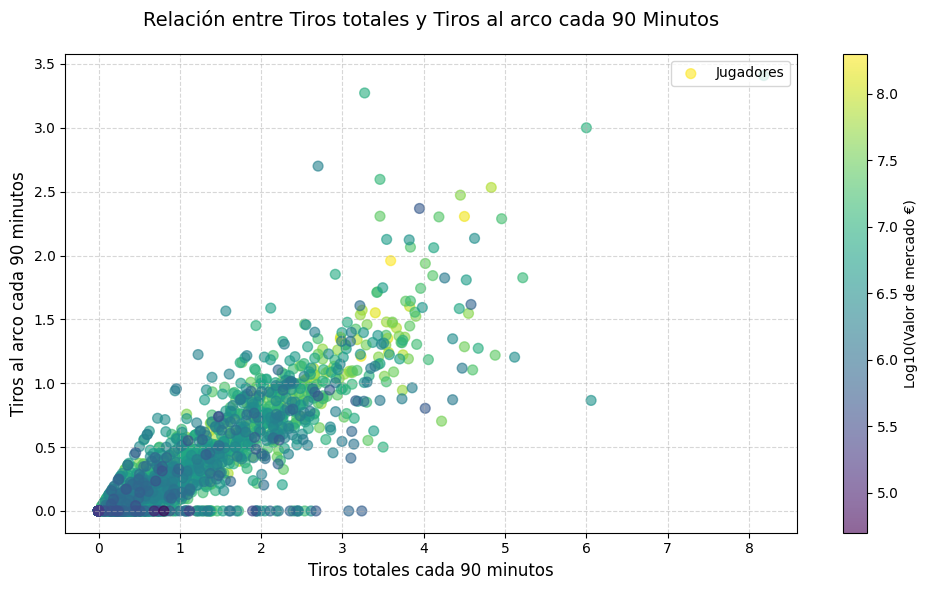

In [36]:
# Configuración de estilo
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Normalizar las métricas por 90 minutos
tiros_al_arco_90 = 90 * df_grafico['TirosAlArco'] / df_grafico['Minutos'] # Tiros al arco cada 90 minutos
tiros_90 = 90 * df_grafico['Tiros'] / df_grafico['Minutos']               # Tiros cada 90 minutos

plt.scatter(
    x=tiros_90,
    y=tiros_al_arco_90,
    c=np.log10(df_grafico['ValorMercado']),  # Escala logarítmica base 10
    cmap='viridis',
    alpha=0.6,
    s=50
)
cbar = plt.colorbar()
cbar.set_label('Log10(Valor de mercado €)', fontsize=10)

# Títulos y etiquetas
plt.title('Relación entre Tiros totales y Tiros al arco cada 90 Minutos', fontsize=14, pad=20)
plt.xlabel('Tiros totales cada 90 minutos', fontsize=12)
plt.ylabel('Tiros al arco cada 90 minutos', fontsize=12)

# Grid y leyenda
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Jugadores'], loc='upper right')

# Mostrar gráfico
plt.tight_layout()  # Evita cortes en etiquetas
plt.show()

Podríamos también experimentar cómo afecta la estadística esta del xG a los goles de un jugaador, veamos qué onda...

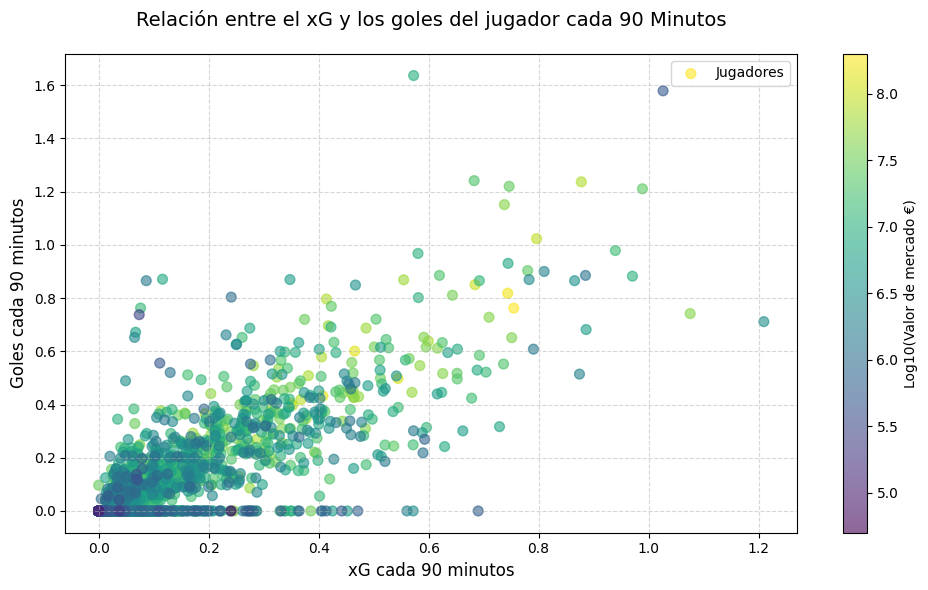

In [37]:
# Configuración de estilo
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Normalizar las métricas por 90 minutos
xG_90 = 90 * df_grafico['xG'] / df_grafico['Minutos']          # xG del jugador cada 90 minutos
goles_90 = 90 * df_grafico['Goles'] / df_grafico['Minutos']    # Goles cada 90 minutos

plt.scatter(
    x=xG_90,
    y=goles_90,
    c=np.log10(df_grafico['ValorMercado']),  # Escala logarítmica base 10
    cmap='viridis',
    alpha=0.6,
    s=50
)
cbar = plt.colorbar()
cbar.set_label('Log10(Valor de mercado €)', fontsize=10)

# Títulos y etiquetas
plt.title('Relación entre el xG y los goles del jugador cada 90 Minutos', fontsize=14, pad=20)
plt.xlabel('xG cada 90 minutos', fontsize=12)
plt.ylabel('Goles cada 90 minutos', fontsize=12)

# Grid y leyenda
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Jugadores'], loc='upper right')

# Mostrar gráfico
plt.tight_layout()  # Evita cortes en etiquetas
plt.show()

In [38]:
df_grafico[(goles_90>1.4) & (xG_90>1.0)]

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
1992,Noah Edjouma,Toulouse,Ligue 1,"MF,FW",19,7,114,2,0,1.3,...,1,0,0,2,1.01,1.3,2,1,5,3


In [ ]:
# Definimos una función que nos devuelva los n jugadores más parecidos para un jugador determinado
def jugadores_recomendados (nombre_jugador, cant_recomendaciones, df_num):
    # Obtenemos el índice del jugador
    ind_jugador = tmarket[tmarket["player"]==nombre_jugador].index[0]

    # Inicializamos un NearestNeighbors que busque los n+1 jugadores más parecidos al buscado (porque incluye al jugador buscado)
    neighbors = NearestNeighbors(n_neighbors = cant_recomendaciones+1).fit(df_num)

    # Obtenemos las distancias a esos jugadores y sus índices
    distances, indices = neighbors.kneighbors(df_num.iloc[[ind_jugador]])

    # Devolvemos el dataset evaluado en esos índices
    res = tmarket.iloc[indices.flatten()]

    # Eliminamos de la lista al mismo jugador
    res = res.drop(ind_jugador, axis=0)
    
    return res